# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

Consulted GPT to assist with writing code

* Mitch Verhelle
* Neo Eloff
* Eric Kopen
* Kailin Hong

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear, minimize
from sklearn.decomposition import PCA

In [4]:
path='../data/'
file='treasury_quotes_2024-10-31.xlsx'
quotes=pd.read_excel(path+file, 'quotes')
select=pd.read_excel(path+file, 'selected quotes')

FileNotFoundError: [Errno 2] No such file or directory: '../data/treasury_quotes_2024-10-31.xlsx'

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [4]:
data = select.copy()

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [5]:
FACE_VALUE = 100
ANNUAL_PAYMENT_FREQ = 2

def generate_cashflows(bond):
    issue_date = pd.to_datetime(bond['issue date'])
    maturity_date = pd.to_datetime(bond['maturity date'])
    coupon_payment = (bond['cpn rate'] / 100 * FACE_VALUE) / ANNUAL_PAYMENT_FREQ
    payment_dates = pd.date_range(start=issue_date, end=maturity_date, freq='6ME')
    payment_dates = payment_dates + pd.offsets.MonthEnd(0)
    cashflows = pd.Series(coupon_payment, index=payment_dates)
    cashflows.loc[maturity_date] = cashflows.get(maturity_date, 0) + FACE_VALUE
    return cashflows

cashflows_dict = {row['KYTREASNO']: generate_cashflows(row) for _, row in data.iterrows()}
cashflow_matrix = pd.DataFrame(cashflows_dict)
cashflow_matrix.fillna(0, inplace=True)
cashflow_matrix.sort_index(inplace=True)
cashflow_matrix = cashflow_matrix.T
cashflow_matrix


,2022-04-30,2022-10-31,2023-04-30,2023-10-31,2024-04-30,2024-10-31,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
208042,0.000,0.0000,1.9375,1.9375,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,0.000,0.0000,0.0000,2.5000,2.5000,2.5000,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,0.000,0.0000,0.0000,0.0000,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,0.000,0.0000,0.0000,0.0000,0.0000,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.375,1.3750,1.3750,1.3750,1.3750,1.3750,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,0.000,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,0.000,0.0000,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,0.000,0.0000,0.0000,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,0.000,0.0000,0.0000,0.0000,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000
208305,0.000,0.0000,0.0000,0.0000,0.0000,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [6]:
p = data['dirty price'].values
C = cashflow_matrix.values

bounds = (-np.inf, np.inf) # (0, np.inf) for non-negativity

result = lsq_linear(C, p, bounds=bounds)
z = result.x
discount_factors=pd.Series(z, index=cashflow_matrix.columns).sort_index()[6:] # the first maturity date is at the 6th entry, meaning we need to omit the prior days as they have values that won't make sense.

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

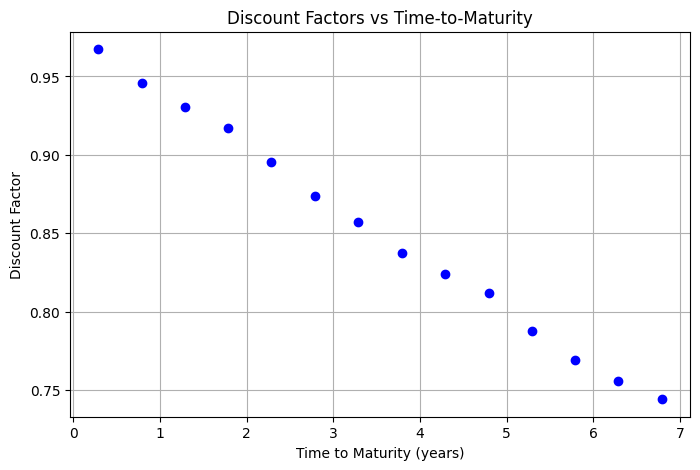

In [7]:
valuation_date = pd.to_datetime("2025-01-15")
time_to_maturity = (discount_factors.index - valuation_date).days / 365.25
valid = time_to_maturity > 0
time_to_maturity = time_to_maturity[valid]
z_valid = discount_factors.values[valid]

# Plot Discount Factors vs Time-to-Maturity (for the entire schedule)
plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, z_valid, marker='o', linestyle='-', color='b')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Discount Factor')
plt.title('Discount Factors vs Time-to-Maturity')
plt.grid(True)
plt.show()



Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

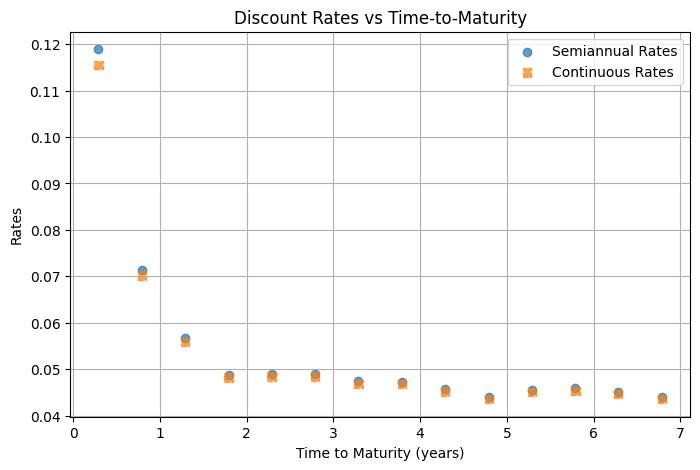

In [8]:

semiannual_rates = 2 * ((1 / z_valid) ** (1 / (2 * time_to_maturity)) - 1)
continuous_rates = -np.log(z_valid) / time_to_maturity

plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, semiannual_rates, marker='o', linestyle='-', label='Semiannual Rates', alpha=.7)
plt.scatter(time_to_maturity, continuous_rates, marker='s', linestyle='--', label='Continuous Rates', alpha=.7)
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Rates')
plt.title('Discount Rates vs Time-to-Maturity')
plt.legend()
plt.grid(True)
plt.show()


### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [9]:
coupon_increase = 0.005
FACE_VALUE = 100
ANNUAL_PAYMENT_FREQ = 2

def generate_cashflows(bond, coupon_increase):
    issue_date = pd.to_datetime(bond['issue date'])
    maturity_date = pd.to_datetime(bond['maturity date'])
    coupon_payment = ((bond['cpn rate'] + coupon_increase) / 100 * FACE_VALUE) / ANNUAL_PAYMENT_FREQ
    payment_dates = pd.date_range(start=issue_date, end=maturity_date, freq='6ME')
    payment_dates = payment_dates + pd.offsets.MonthEnd(0)
    cashflows = pd.Series(coupon_payment, index=payment_dates)
    cashflows.loc[maturity_date] = cashflows.get(maturity_date, 0) + FACE_VALUE
    return cashflows

cashflows_dict = {row['KYTREASNO']: generate_cashflows(row, coupon_increase) for _, row in data.iterrows()}
cashflow_matrix = pd.DataFrame(cashflows_dict)
cashflow_matrix.fillna(0, inplace=True)
cashflow_matrix.sort_index(inplace=True)
cashflow_matrix = cashflow_matrix.T
cashflow_matrix

z += coupon_increase

C_prime = cashflow_matrix.values
new_prices = C_prime @ z
data['new_price'] = new_prices
data[['dirty price', 'new_price']]


,dirty price,new_price
0,99.717351,100.269701
1,100.651113,101.219726
2,100.945312,101.514392
3,99.937500,100.499070
4,96.765625,97.354550
5,100.003906,100.632802
6,97.921875,98.535663
7,102.603516,103.257047
8,101.912109,102.560527
9,99.894531,100.530801


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

In [10]:
quotes=pd.read_excel(path+file, 'quotes')
data=quotes.copy()

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

In [11]:
filtered_data = data.dropna(subset=['ytm'])
filtered_data = filtered_data[filtered_data['ytm'] >= 0]
print(filtered_data['type'].unique())
# filtered_data = filtered_data[(filtered_data['type'] == 'bond') | (filtered_data['type'] == 'note')]
filtered_data

['bill' 'bond' 'note']


,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.000,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
1,208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.000,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
2,208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.000,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
3,208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.000,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
4,204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.500,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,208107,bond,2024-10-31,2023-08-15,2053-08-15,28.788501,0.418478,4.125,93.968750,94.019531,93.994141,0.863111,94.857252,0.044991
443,208149,bond,2024-10-31,2023-11-15,2053-11-15,29.040383,0.918478,4.750,104.281250,104.335938,104.308594,2.181386,106.489980,0.044837
445,208178,bond,2024-10-31,2024-02-15,2054-02-15,29.292266,0.418478,4.250,96.125000,96.171875,96.148438,0.889266,97.037704,0.044873
446,208233,bond,2024-10-31,2024-05-15,2054-05-15,29.535934,0.918478,4.625,102.328125,102.390625,102.359375,2.123981,104.483356,0.044809


In [12]:
coupon_increase = 0
FACE_VALUE = 100
ANNUAL_PAYMENT_FREQ = 2

def generate_cashflows(bond, coupon_increase=0, freq='6ME', start='issue date', end='maturity date'):
    start_date = pd.to_datetime(bond[start])
    end_date = pd.to_datetime(bond[end])
    maturity_date = pd.to_datetime(bond['maturity date'])
    coupon_payment = ((bond['cpn rate'] + coupon_increase) / 100 * FACE_VALUE) / ANNUAL_PAYMENT_FREQ
    payment_dates = pd.date_range(start=start_date, end=end_date, freq=freq)
    payment_dates = payment_dates.to_period('M').to_timestamp()
    def adjust_day(date):
        try:
            return date.replace(day=maturity_date.day)
        except ValueError:  # If the day is out of range, use the month's last day
            return date + pd.offsets.MonthEnd(0)

    payment_dates = payment_dates.map(adjust_day)
    cashflows = pd.Series(coupon_payment, index=payment_dates)
    cashflows.loc[maturity_date] = cashflows.get(maturity_date, 0) + FACE_VALUE
    return cashflows

cashflows_dict = {row['KYTREASNO']: generate_cashflows(row, coupon_increase=coupon_increase, freq='-6ME', start='maturity date', end='issue date') for _, row in filtered_data.iterrows()}
cashflow_matrix = pd.DataFrame(cashflows_dict)
cashflow_matrix.fillna(0, inplace=True)
cashflow_matrix.sort_index(inplace=True)
cashflow_matrix = cashflow_matrix.T
cashflow_matrix


,1994-05-15,1994-11-15,1995-02-15,1995-05-15,1995-08-15,1995-11-15,1996-02-15,1996-05-15,1996-08-15,1996-11-15,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
208246,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208222,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208247,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208223,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
204083,3.75,3.75,0.0,3.75,0.0,3.75,0.0,3.75,0.0,3.75,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000



Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [13]:
print()
print('head')
display(cashflow_matrix.head())
print()
print('tail')
display(cashflow_matrix.tail())

total_cashflows_by_date = cashflow_matrix.sum(axis=0)
max_cashflow_date = total_cashflows_by_date.idxmax()
max_cashflow_amount = total_cashflows_by_date.max()
print(f"The date with the most total cashflow across all issues is {max_cashflow_date}, with a total cashflow of ${max_cashflow_amount:.2f}.")

issues_paying_by_date = (cashflow_matrix > 0).sum(axis=0)
max_issues_date = issues_paying_by_date.idxmax()
max_issues_count = issues_paying_by_date.max()
print(f"The date with the most issues paying is {max_issues_date}, with {max_issues_count} issues.")



head


,1994-05-15,1994-11-15,1995-02-15,1995-05-15,1995-08-15,1995-11-15,1996-02-15,1996-05-15,1996-08-15,1996-11-15,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
208246,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,3.75,3.75,0.0,3.75,0.0,3.75,0.0,3.75,0.0,3.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



tail


,1994-05-15,1994-11-15,1995-02-15,1995-05-15,1995-08-15,1995-11-15,1996-02-15,1996-05-15,1996-08-15,1996-11-15,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
208107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000
208279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.125,0.0000,102.125


The date with the most total cashflow across all issues is 2025-02-15 00:00:00, with a total cashflow of $435.25.
The date with the most issues paying is 2024-08-15 00:00:00, with 80 issues.


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [14]:
cashflow_matrix = cashflow_matrix.loc[:, cashflow_matrix.columns.isin(filtered_data['maturity date'])]
filtered_data=filtered_data[filtered_data['KYTREASNO'].isin(cashflow_matrix.index)]

display(cashflow_matrix)

print(cashflow_matrix.shape)
print(filtered_data.shape)

p = filtered_data['dirty price'].values
C_hat = cashflow_matrix.values
bounds = (-np.inf, np.inf) # (0, np.inf) If want positive results
result = lsq_linear(C_hat, p, bounds=bounds)
z = result.x
discount_factors = pd.Series(z, index=cashflow_matrix.columns).sort_index()
display(discount_factors)

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
208246,100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208222,0.0,100.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208247,0.0,0.0,100.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
208223,0.0,0.0,0.0,100.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
204083,0.0,0.0,0.0,0.0,103.7500,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0.0,0.0,0.0,0.0,2.3750,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000


(395, 265)
(395, 14)


2024-11-05    0.999479
2024-11-07    0.999224
2024-11-12    0.998576
2024-11-14    0.998328
2024-11-15    0.998509
                ...   
2053-08-15    0.315897
2053-11-15    0.338473
2054-02-15    0.311901
2054-05-15    0.329894
2054-08-15    0.306253
Length: 265, dtype: float64

head


2024-11-05    0.999479
2024-11-07    0.999224
2024-11-12    0.998576
2024-11-14    0.998328
2024-11-15    0.998509
dtype: float64

tail


2053-08-15    0.315897
2053-11-15    0.338473
2054-02-15    0.311901
2054-05-15    0.329894
2054-08-15    0.306253
dtype: float64

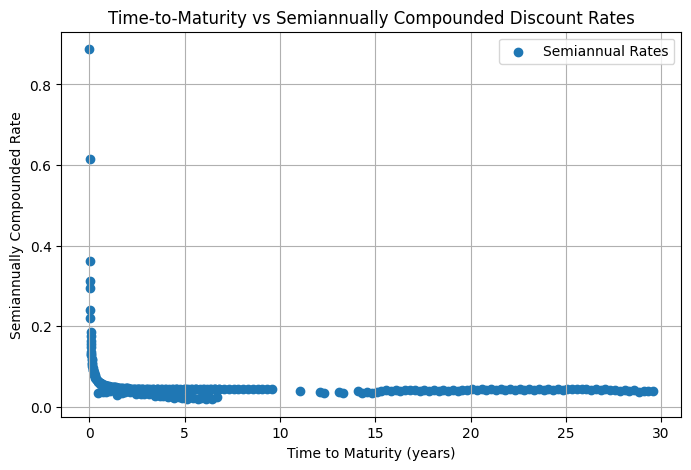

In [15]:
print('head')
display(discount_factors.head())
print('tail')
display(discount_factors.tail())

# Plot
valuation_date = pd.to_datetime("2025-01-16")

time_to_maturity = (discount_factors.index - valuation_date).days / 365.25

valid = time_to_maturity > 0
time_to_maturity = time_to_maturity[valid]
discount_factors = discount_factors[valid]

semiannual_rates = 2 * ((1 / discount_factors) ** (1 / (2 * time_to_maturity)) - 1)

plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, semiannual_rates, marker='o', linestyle='-', label='Semiannual Rates')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Semiannually Compounded Rate')
plt.title('Time-to-Maturity vs Semiannually Compounded Discount Rates')
plt.grid(True)
plt.legend()
plt.show()

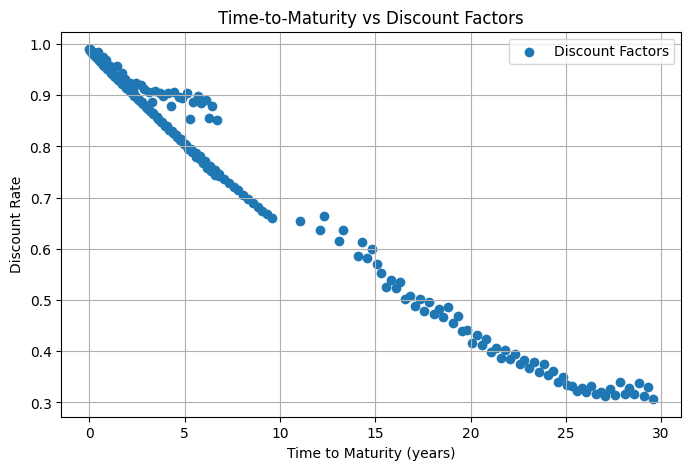

In [16]:
plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, discount_factors, marker='o', linestyle='-', label='Discount Factors')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Discount Rate')
plt.title('Time-to-Maturity vs Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


In [17]:
cashflow_matrix = cashflow_matrix.loc[:, cashflow_matrix.columns.isin(filtered_data['maturity date'])]
filtered_data = filtered_data[filtered_data['KYTREASNO'].isin(cashflow_matrix.index)]

p = filtered_data['dirty price'].values
C_hat = cashflow_matrix.values


def weighting_policy(issue_dates, policy="equal"):
    weights=np.ones(len(issue_dates))
    if policy=='linear':
        weights=(issue_dates.max() - issue_dates).dt.days
    elif policy=='inverse': # For more weight on more recently used treasuries, since it takes today-issue_date, so it'll assign it larger weights compared to further back dates.
        epsilon=0
        weights = 1 / ((pd.to_datetime("2025-01-16") - issue_dates).dt.days + epsilon)
    elif policy == 'semiannual':
        max_date = issue_dates.max()
        blocks = ((max_date - issue_dates) // pd.Timedelta(days=182.5)).astype(int)
        weights = 1 / (2 ** blocks)
    return weights / weights.max()


issue_dates = pd.to_datetime(filtered_data['issue date'])
weights = weighting_policy(issue_dates, 'inverse')  # returns normalized weights with more recently used dates getting more weight than less recently used treasuries.

W = np.diag(weights)
C_weighted = W @ C_hat
p_weighted = W @ p

bounds = (-np.inf, np.inf)  # Use (0, np.inf) for non-negative constraints
result = lsq_linear(C_weighted, p_weighted, bounds=bounds)
z = result.x

discount_factors = pd.Series(z, index=cashflow_matrix.columns).sort_index()

display(discount_factors)

print('head')
display(discount_factors.head())
print('tail')
display(discount_factors.tail())



2024-11-05    0.999479
2024-11-07    0.999224
2024-11-12    0.998576
2024-11-14    0.998328
2024-11-15    0.998276
                ...   
2053-08-15    0.316326
2053-11-15    0.339135
2054-02-15    0.312335
2054-05-15    0.330525
2054-08-15    0.306677
Length: 265, dtype: float64

head


2024-11-05    0.999479
2024-11-07    0.999224
2024-11-12    0.998576
2024-11-14    0.998328
2024-11-15    0.998276
dtype: float64

tail


2053-08-15    0.316326
2053-11-15    0.339135
2054-02-15    0.312335
2054-05-15    0.330525
2054-08-15    0.306677
dtype: float64

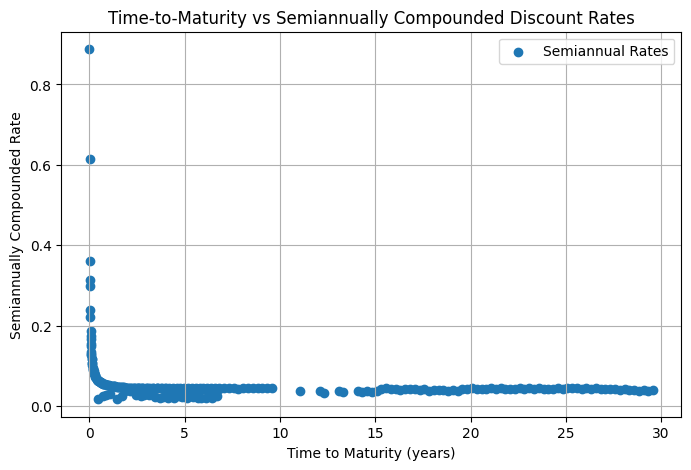

In [18]:
# Plot
valuation_date = pd.to_datetime("2025-01-16")

time_to_maturity = (discount_factors.index - valuation_date).days / 365.25
# time_to_maturity = filtered_data['ttm'] ?? I want to, but I also know I need to have ttm's for each DATE, not for each treasury, since the ttms get plotted with the discount rates which is by date. OR I could match up the discount rate dates with maturity dates for each treasury and then get their ttms from that... but then if I have multiple treasuries per date, which one do I choose?

valid = time_to_maturity > 0
time_to_maturity = time_to_maturity[valid]
discount_factors = discount_factors[valid]

semiannual_rates = 2 * ((1 / discount_factors) ** (1 / (2 * time_to_maturity)) - 1)

plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, semiannual_rates, marker='o', linestyle='-', label='Semiannual Rates')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Semiannually Compounded Rate')
plt.title('Time-to-Maturity vs Semiannually Compounded Discount Rates')
plt.grid(True)
plt.legend()
plt.show()

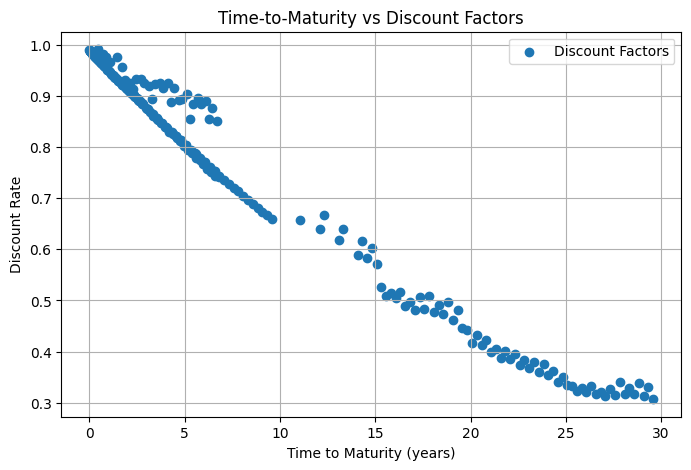

In [19]:
plt.figure(figsize=(8, 5))
plt.scatter(time_to_maturity, discount_factors, marker='o', linestyle='-', label='Discount Factors')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Discount Rate')
plt.title('Time-to-Maturity vs Discount Factors')
plt.grid(True)
plt.legend()
plt.show()

### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [20]:
# Nelson-Siegel model
def nelson_siegel(t, beta0, beta1, beta2, lambd):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-lambd * t)) / (lambd * t)
    term3 = beta2 * ((1 - np.exp(-lambd * t)) / (lambd * t) - np.exp(-lambd * t))
    return term1 + term2 + term3

# Objective function to minimize
def objective(params, maturities, yields):
    beta0, beta1, beta2, lambd = params
    model_yields = nelson_siegel(maturities, beta0, beta1, beta2, lambd)
    return np.sum((yields - model_yields) ** 2)

maturity_dates = pd.to_datetime(cashflow_matrix.columns)
maturity_ttm = (maturity_dates - valuation_date).days / 365.25

maturities = np.array(filtered_data['ttm'].values)
observed_yields = np.array(filtered_data['ytm'].values)

initial_params = [2.0, -1.0, 0.5, 0.5]

result = minimize(objective, initial_params, args=(maturities, observed_yields), method='L-BFGS-B')

beta0, beta1, beta2, lambd = result.x

fitted_yields = nelson_siegel(maturity_ttm, beta0, beta1, beta2, lambd)

discount_factors_NS = np.exp(-maturity_ttm * fitted_yields / 100)

discount_factors_NS = pd.Series(discount_factors_NS, index=maturity_dates)

discount_factors_NS


2024-11-05    1.000084
2024-11-07    1.000082
2024-11-12    1.000076
2024-11-14    1.000073
2024-11-15    1.000072
                ...   
2053-08-15    0.986986
2053-11-15    0.986864
2054-02-15    0.986742
2054-05-15    0.986623
2054-08-15    0.986501
Length: 265, dtype: float64

In [21]:
p = filtered_data['dirty price'].values
C_hat = cashflow_matrix.values

weights = weighting_policy(pd.to_datetime(filtered_data['issue date']), 'equal')
W = np.diag(weights)
C_equally_weighted = W @ C_hat
p_equally_weighted = W @ p

result = lsq_linear(C_equally_weighted, p_equally_weighted, bounds=(-np.inf, np.inf))
z_OLS = result.x

discount_factors_OLS = pd.Series(z, index=cashflow_matrix.columns).sort_index()


In [22]:
# Align ttm with discount factors by maturity dates
maturity_dates = cashflow_matrix.columns  # Maturity dates used in OLS discount factors
maturity_ttm = (pd.to_datetime(maturity_dates) - valuation_date).days / 365.25  # Compute ttm for these dates

# Map NS and OLS discount factors to these maturity dates
discount_factors_OLS = discount_factors_OLS.reindex(maturity_dates)
discount_factors_NS = discount_factors_NS.reindex(maturity_dates)

# Semiannual rates for OLS and NS
semiannual_rates_ols = 2 * ((1 / discount_factors_OLS) ** (1 / (2 * maturity_ttm)) - 1)
semiannual_rates_ns = 2 * ((1 / discount_factors_NS) ** (1 / (2 * maturity_ttm)) - 1)

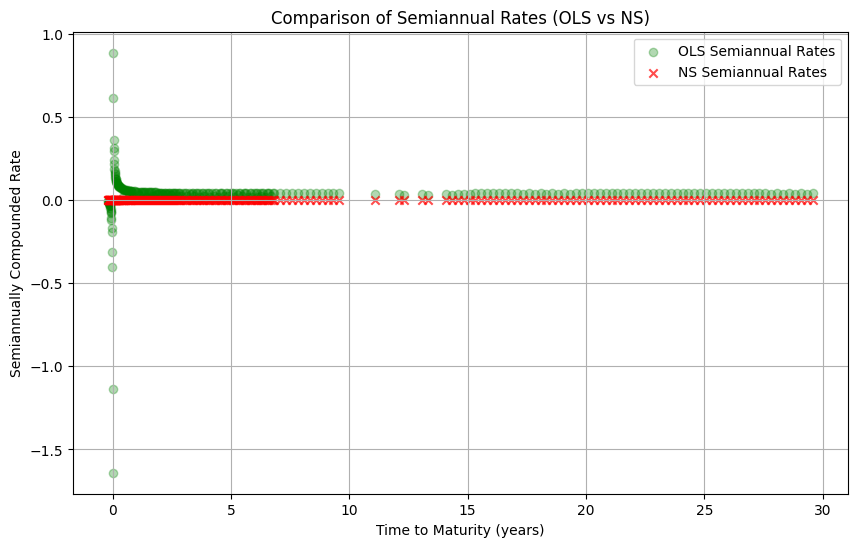

In [23]:
# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(maturity_ttm, semiannual_rates_ols, label='OLS Semiannual Rates', marker='o', alpha=.3, color='g')
plt.scatter(maturity_ttm, semiannual_rates_ns, label='NS Semiannual Rates', marker='x', alpha=.7, color='r')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Semiannually Compounded Rate')
plt.title('Comparison of Semiannual Rates (OLS vs NS)')
plt.legend()
plt.grid(True)
plt.show()


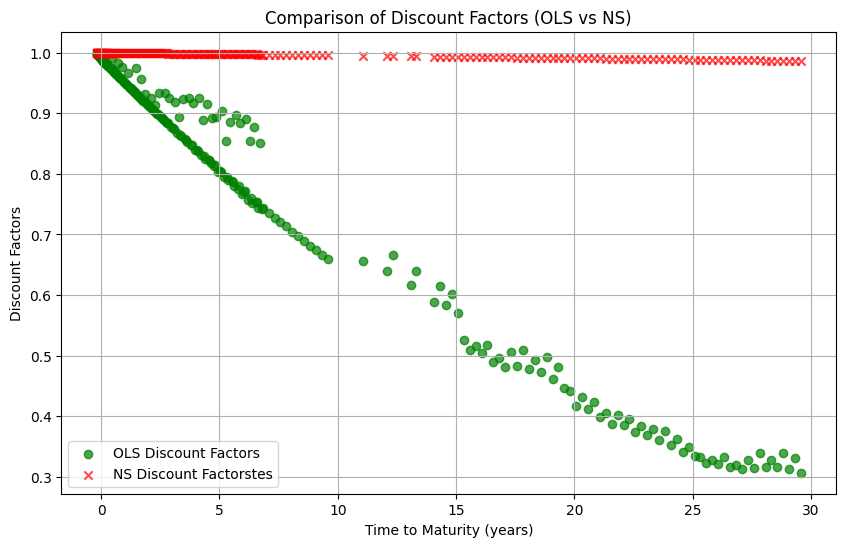

In [24]:
# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(maturity_ttm, discount_factors_OLS, label='OLS Discount Factors', marker='o', alpha=.7, color='g')
plt.scatter(maturity_ttm, discount_factors_NS, label='NS Discount Factorstes', marker='x', alpha=.7, color='r')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Discount Factors')
plt.title('Comparison of Discount Factors (OLS vs NS)')
plt.legend()
plt.grid(True)
plt.show()


# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



In [25]:
yields = pd.read_excel(path+'yields.xlsx', sheet_name='yields').reset_index(drop=True).set_index('caldt')
data=yields.copy()
data.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [26]:
data['level']=(yields.sum(axis=1))/len(yields.columns)
data['slope']=yields[30]-yields[1]
data['curvature']=-yields[1]+2*yields[10]-yields[30]
factors=data[['level', 'slope', 'curvature']]
display(factors.describe()[1:3])
factors.corr()

,level,slope,curvature
mean,5.475250,1.109788,0.671817
std,2.914725,1.480255,0.971945


,level,slope,curvature
level,1.000000,-0.375967,-0.169325
slope,-0.375967,1.000000,0.647671
curvature,-0.169325,0.647671,1.000000


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [27]:
pca = PCA(n_components=.999)

pca_scores = pca.fit_transform(yields)

n_components_used = pca.n_components_

print(f'Number of components selected: {n_components_used}')

cols = []
for col in yields.columns:
    cols.append(str(col))
yields.columns=cols

print(f'Number of components selected: {n_components_used}')

# Dictionary to hold individual DataFrames for each PC
pc_dfs = {}

for i in range(2):
    pc_label = f'PC{i+1}'
    
    # Factor loadings for PC i: weights for each maturity
    loadings = pd.Series(pca.components_[i], index=yields.columns, name='loading')
    
    # Create a DataFrame with loadings and replicate explained variance across maturities
    df_pc = pd.DataFrame(loadings)
    
    # Store the DataFrame in the dictionary
    pc_dfs[pc_label] = df_pc


combined_df = pd.concat(pc_dfs, axis=1)
display(combined_df)


explained_variances = pca.explained_variance_ratio_

pc_labels = [f'PC{i+1}' for i in range(len(explained_variances))]

df_explained = pd.DataFrame(
    {'explained_variance': explained_variances},
    index=pc_labels
)
display(df_explained.T)

print('Total ', df_explained.sum(axis=0))

Number of components selected: 4
Number of components selected: 4


,PC1,PC2
,loading,loading
1,0.411464,0.591006
2,0.411054,0.399298
5,0.392784,0.046806
7,0.378353,-0.087439
10,0.363380,-0.202674
20,0.344069,-0.438856
30,0.337450,-0.497760


,PC1,PC2,PC3,PC4
explained_variance,0.9707,0.025278,0.002947,0.000454


Total  explained_variance    0.99938
dtype: float64


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [28]:
pca_factors = pd.DataFrame(pca_scores[:,0:2], columns=['PCA1', 'PCA2'])
correlations = pd.DataFrame(index=['level', 'slope'], columns=pca_factors.columns)

for factor in correlations.index:
    for pca_factor in pca_factors.columns:
        correlations.loc[factor, pca_factor] = np.corrcoef(factors[factor], pca_factors[pca_factor])[0, 1]

print("Correlations between ad-hoc factors and PCA factors:")
print(correlations)


Correlations between ad-hoc factors and PCA factors:
           PCA1      PCA2
level  0.999932 -0.011596
slope -0.386618 -0.917761


<span style="color:blue">

Almost all of the variance (97.07%) is explained by PC1. Then about 2.53% of the variance is explained by PC2 and that leaves about a half of a percent of variance to be explained by the rest of the principal components. This indicates that a single function linear combination of each yield type could explain the majority of the variance.

We also see that slope and level are pretty highly correlated to PC2 and PC1 respectively. PC1 and level are nearly perfectly correlated, and PCA2 and slope are nearly perfectly negatively correlated, suggesting that the statistical nature of finding factors aligns well with the theoretical motivation for defining the level and slope of the yield curve. But because that correlation is not 1, these two factors alone will explain less of the variance in the yields than the principal components because the PCs find the eigenvectors which maximize the variance. This could be chalked up to noise or some other underlying factors.

<span>